## *Imports*

Install necessary packages for emotional classifer.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Lambda, Layer
from transformers import TFAutoModel, AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\User

## *Data Preprocessing & Splitting*

In [2]:
df = pd.read_csv("EmotionDataset/emotions_dataset.csv")

word_tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>")
word_tokenizer.fit_on_texts(df['sentence'])

bert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

sentences = df['sentence'].tolist()
labels = pd.factorize(df['emotion'])[0]

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_word_tokens = word_tokenizer.texts_to_sequences(X_train)
X_test_word_tokens = word_tokenizer.texts_to_sequences(X_test)

X_train_bert_tokens = bert_tokenizer(X_train, padding="max_length", truncation=True, max_length=28, return_tensors="tf")
X_test_bert_tokens = bert_tokenizer(X_test, padding="max_length", truncation=True, max_length=28, return_tensors="tf")

with open("word_tokenizer.pkl", "wb") as f:
    pickle.dump(word_tokenizer, f)

with open("bert_tokenizer.pkl", "wb") as f:
    pickle.dump(bert_tokenizer, f)

print("Word-based tokenization:")
print("X_train shape:", len(X_train_word_tokens))
print("Y_train shape:", len(y_train))
print("X_test shape:", len(X_test_word_tokens))

print("\nBERT-based tokenization:")
print("X_train shape:", X_train_bert_tokens['input_ids'].shape)
print("X_test shape:", X_test_bert_tokens['input_ids'].shape)


Word-based tokenization:
X_train shape: 4935
Y_train shape: 4935
X_test shape: 1234

BERT-based tokenization:
X_train shape: (4935, 28)
X_test shape: (1234, 28)


In [3]:
sentence_lengths = [len(sentence.split()) for sentence in sentences]
print(f"Average sentence length: {np.mean(sentence_lengths)}")
print(f"Max sentence length: {np.max(sentence_lengths)}")

MAX_SEQ_LENGTH_TMP = min(np.max(sentence_lengths), 50) 

Average sentence length: 8.241692332630896
Max sentence length: 28


In [4]:
print("Class distribution in training set:", pd.Series(y_train).value_counts())

Class distribution in training set: 6     452
0     440
11    419
3     416
7     414
9     413
1     407
8     404
10    400
5     398
2     390
4     382
Name: count, dtype: int64


## *Training High-Parameter Model (BERT-based)*

In [27]:
MODEL_NAME = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFAutoModel.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
MAX_LEN = 28

print("X_train input_ids shape:", X_train_bert_tokens['input_ids'].shape)
print("X_train attention_mask shape:", X_train_bert_tokens['attention_mask'].shape)
print("y_train shape:", len(y_train))

X_train input_ids shape: (4935, 28)
X_train attention_mask shape: (4935, 28)
y_train shape: 4935


In [29]:
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask)
        return bert_output.pooler_output  # Extract CLS token output

input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_output = BertLayer(bert_model)([input_ids, attention_mask])

dense = Dense(128, activation='relu')(bert_output)
output = Dense(len(set(labels)), activation='softmax')(dense)

model_parsbert = Model(inputs=[input_ids, attention_mask], outputs=output)

model_parsbert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_parsbert.fit(
    x=[X_train_bert_tokens['input_ids'], X_train_bert_tokens['attention_mask']], 
    y=np.array(y_train),  # Ensure y_train is a NumPy array
    epochs=15, batch_size=8, 
    validation_data=([X_test_bert_tokens['input_ids'], X_test_bert_tokens['attention_mask']], np.array(y_test))
)


Epoch 1/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 114s 173ms/step - accuracy: 0.6308 - loss: 1.1656 - val_accuracy: 0.8736 - val_loss: 0.4039
Epoch 2/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 115s 186ms/step - accuracy: 0.8746 - loss: 0.3729 - val_accuracy: 0.8979 - val_loss: 0.2917
Epoch 3/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 118s 191ms/step - accuracy: 0.9098 - loss: 0.2725 - val_accuracy: 0.8922 - val_loss: 0.2964
Epoch 4/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9163 - loss: 0.2398

## *Convert BERT Model to TFLite*

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_parsbert)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_parsbert = converter.convert()

with open("Models/parsbert_emotion_model.tflite", "wb") as f:
    f.write(tflite_parsbert)

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpv312wg83\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpv312wg83\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpv312wg83'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 28), dtype=tf.int32, name='input_ids'), TensorSpec(shape=(None, 28), dtype=tf.int32, name='attention_mask')]
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  1986278093840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278094608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278092880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278094416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278093264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278093456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278093072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278094992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278092304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1986278094800

## *Training Lightweight Model (LSTM)*

In [10]:
MAX_SEQ_LENGTH = 28

X_train_padded = pad_sequences(X_train_word_tokens, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_word_tokens, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

model_lstm = Sequential([
    Embedding(input_dim=2000, output_dim=64, input_length=MAX_SEQ_LENGTH),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(16, activation='relu'),
    Dense(len(set(labels)), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
print("Sample of padded sequence:", X_train_padded[0])

Sample of padded sequence: [  8   6 328   2 196 118 208   4  24  10   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [12]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [13]:
model_lstm.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1098 - loss: 2.4330 - val_accuracy: 0.2731 - val_loss: 1.9768
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3028 - loss: 1.8233 - val_accuracy: 0.4311 - val_loss: 1.4209
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4782 - loss: 1.3280 - val_accuracy: 0.5632 - val_loss: 1.1518
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5810 - loss: 1.0522 - val_accuracy: 0.6070 - val_loss: 1.0150
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6222 - loss: 0.9104 - val_accuracy: 0.6224 - val_loss: 0.9264


In [14]:
model_lstm.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), class_weight=class_weight_dict)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6665 - loss: 0.8126 - val_accuracy: 0.6499 - val_loss: 0.9046
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6744 - loss: 0.7848 - val_accuracy: 0.6467 - val_loss: 0.8680
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7172 - loss: 0.6762 - val_accuracy: 0.6694 - val_loss: 0.8966
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7649 - loss: 0.6484 - val_accuracy: 0.7504 - val_loss: 0.7379
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7936 - loss: 0.5441 - val_accuracy: 0.7593 - val_loss: 0.7317
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8158 - loss: 0.4913 - val_accuracy: 0.7755 - val_loss: 0.6394
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8087 - loss: 0.4359 - val_accuracy: 0.7674 - val_loss: 0.6524
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8205 - loss: 0.4025 - val_accuracy:

In [15]:
model_lstm_enhanced = Sequential([
    Embedding(input_dim=2000, output_dim=64, input_length=MAX_SEQ_LENGTH),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(16, activation='relu'),
    Dense(len(set(labels)), activation='softmax')
])

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
model_lstm_enhanced.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
model_lstm_enhanced.fit(X_train_padded, y_train, epochs=20, batch_size=16, validation_data=(X_test_padded, y_test))

Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1198 - loss: 2.4306 - val_accuracy: 0.4165 - val_loss: 1.7682
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4485 - loss: 1.5524 - val_accuracy: 0.6272 - val_loss: 1.1544
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6253 - loss: 1.0541 - val_accuracy: 0.6694 - val_loss: 0.8753
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7281 - loss: 0.7667 - val_accuracy: 0.7366 - val_loss: 0.7411
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7770 - loss: 0.6109 - val_accuracy: 0.7666 - val_loss: 0.6354
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8009 - loss: 0.5256 - val_accuracy: 0.7739 - val_loss: 0.6133
Epoch 7/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8396 - loss: 0.4427 - val_accuracy: 0.7804 - val_loss: 0.5871
Epoch 8/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8611 - loss: 0.3896 - val_accuracy: 0

## *Convert LSTM Model to TFLite*

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm_enhanced)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Default TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Allow TensorFlow ops if needed
]
converter._experimental_lower_tensor_list_ops = False
tflite_model_lstm = converter.convert()

# Save the TFLite model
with open("Models/lstm_emotion_model_enhanced.tflite", "wb") as f:
    f.write(tflite_model_lstm)

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp_fpadxis\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp_fpadxis\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmp_fpadxis'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  1989162470096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162469520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162469328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162471248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162470288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162470480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162473360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162470864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162474128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162472784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1989162474896

## *Test & Evaluate Models*

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       110
           1       0.41      0.16      0.23       102
           2       0.93      0.95      0.94        97
           3       0.96      0.97      0.97       104
           4       1.00      0.96      0.98        95
           5       0.96      0.99      0.98       100
           6       0.95      0.95      0.95       113
           7       0.94      0.85      0.89       104
           8       0.46      0.77      0.58       101
           9       0.99      1.00      1.00       103
          10       0.87      0.85      0.86       100
          11       0.68      0.75      0.71       105

    accuracy                           0.83      1234
   macro avg       0.83      0.83      0.82      1234
weighted avg       0.83      0.83      0.82      1234



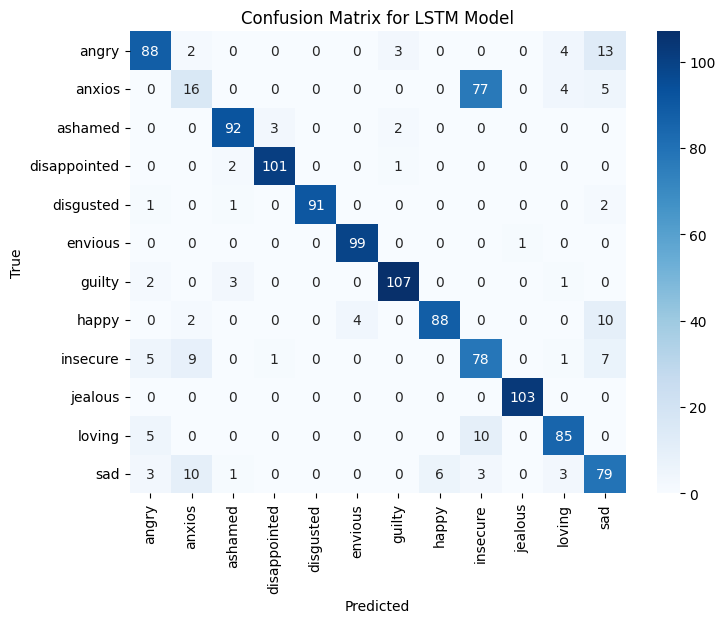

In [19]:
y_pred = np.argmax(model_lstm.predict(X_test_padded), axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['emotion'].unique(), yticklabels=df['emotion'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LSTM Model")
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       110
           1       0.81      0.84      0.83       102
           2       0.95      0.86      0.90        97
           3       0.90      0.97      0.94       104
           4       0.97      0.96      0.96        95
           5       0.88      0.98      0.93       100
           6       0.99      0.94      0.96       113
           7       0.98      0.92      0.95       104
           8       0.80      0.73      0.76       101
           9       0.99      1.00      1.00       103
          10       0.91      0.92      0.92       100
          11       0.71      0.85      0.77       105

    accuracy                           0.89      1234
   macro avg       0.90      0.89      0.89      1234
weighted avg       0.90      0.89      0.89      1234



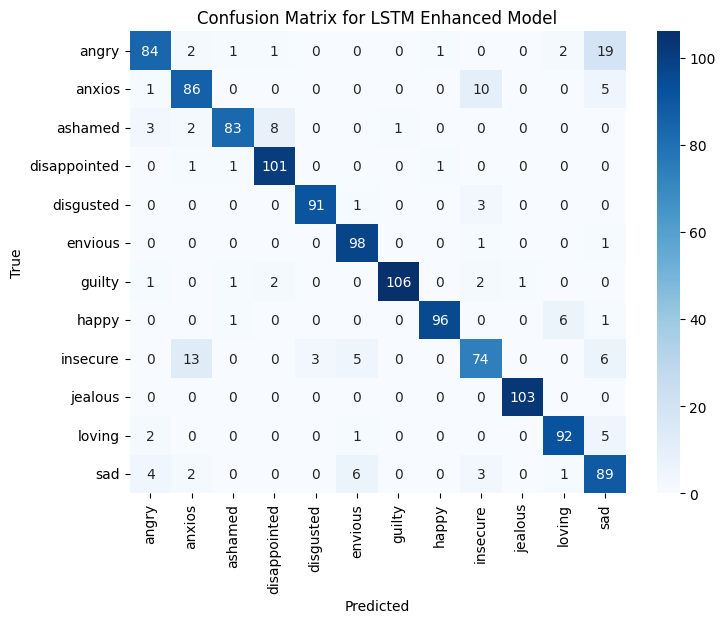

In [20]:
y_pred = np.argmax(model_lstm_enhanced.predict(X_test_padded), axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['emotion'].unique(), yticklabels=df['emotion'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LSTM Enhanced Model")
plt.show()

## *Visualize BERT Rsults*

In [22]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('BERT Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('BERT Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

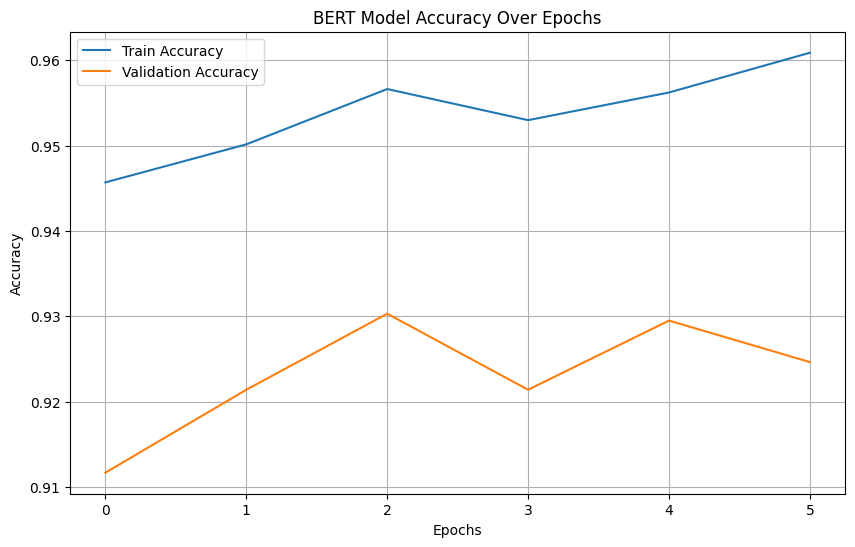

In [24]:
plot_accuracy(history)

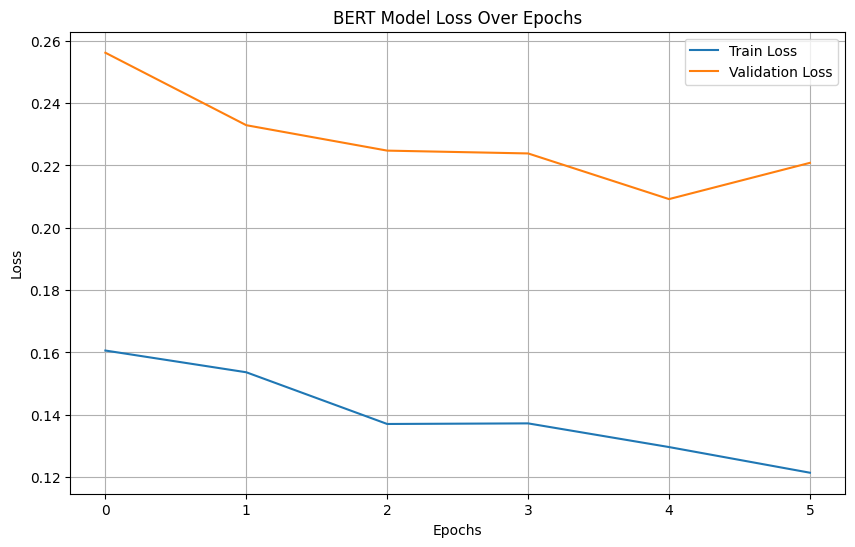

In [25]:
plot_loss(history)